<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>
 

# RNN à la vanille [régression de série temporelle]

In [17]:
# Dans ce notebook, nous allons nous intéresser à une introduction aux RNN sur une tâche de régression
# sur des séries temporelles

# Ce notebook vise à apprendre : 
# - L'organisation des données de séries temporelles numériques pour l'apprentissage d'un RNN
# - L'implémentation d'un RNN à la vanille en TF 
# - L'implémentation exhaustive d'une RNN pour l'inférence en Python
# - Leur comparison numérique

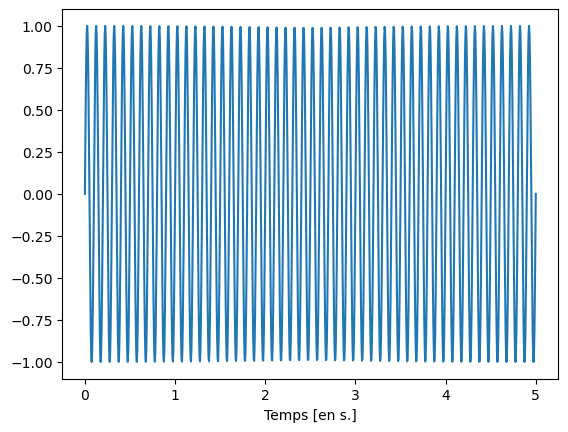

In [18]:
# On importe les librairies de base pour le calcul et l'affichage
import numpy as np
import math
import matplotlib.pyplot as plt

# On crée X périodes d'un sinus de fréquence 10 Hz sur 1000 points
n_samp = 1000
f = 10
tmin = 0
tmax = 5
t = np.linspace(tmin,tmax,n_samp)
x = np.sin(2*math.pi*f*t)
xt=x

# On trace le sinus
plt.plot(t,x)
plt.xlabel("Temps [en s.]")
plt.show()

In [19]:
# On formate les données pour l'entrée du RNN 
# 3 dimensions dans un RNN : (nbatch, ntime, ndim)

# En entrée du RNN, on utilise les len_seq valeurs précédentes pour prédire la valeur courante
# Dimension de l'entrée : (nbatch, len_seq-1, 1)
# Dimension de la sortie : (nbatch, 1)
# On créé autant de batch que nécessaire en découpant les données par paquets de len_seq
len_seq = 10
dataX, dataY = [], []
for i in range(len(x)-len_seq):
    dataX.append([x[i:i+len_seq]])
    dataY.append([x[i+1:i+len_seq+1]])    
dataX = np.array(dataX)
dataY = np.array(dataY)

# On formate dataX pour que ses dimensions soient bien (nbatch, len_seq, 1)
x     = np.reshape(x, (1, n_samp, 1))
dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[2], dataX.shape[1]))
dataY = np.reshape(dataY, (dataY.shape[0], dataY.shape[2], dataY.shape[1]))

# On vérifie le format des données d'entrée et de sortie
print("Dimension des données en entrée : {}" .format(dataX.shape))
print("Dimension des données en sortie : {}" .format(dataY.shape))


Dimension des données en entrée : (990, 10, 1)
Dimension des données en sortie : (990, 10, 1)


In [20]:
# Question 2 : apprendre ce réseau en utilisant TF
# On va comparer 3 configurations :
# 1) hid_dim=4 et stateful=False
# 2) hid_dim=4 et stateful=True
# 3) hid_dim=16 et stateful=True

# on importe les librairies de TF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed

# On créé quelques paramètres d'entrée du réseau
batch_size = 10
hid_dim    = 16  
epochs     = 10
n_dim      = 1

# On instancie le réseau
RNN_model  = Sequential(name="RNN_model")
RNN_model.add(SimpleRNN(units=hid_dim, batch_input_shape=(batch_size, len_seq, n_dim), stateful=True, return_sequences=True, activation='tanh', name='RNN'))
RNN_model.add(TimeDistributed(Dense(1), name='dense'))

# On compile le réseau
RNN_model.compile(loss='mse', optimizer='adam')

# On visualise la structure du réseau
RNN_model.summary()


Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN (SimpleRNN)             (10, 10, 16)              288       
                                                                 
 dense (TimeDistributed)     (10, 10, 1)               17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [21]:
# On entraine le réseau
RNN_model.fit(dataX, dataY, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/10
99/99 - 3s - loss: 0.2010 - 3s/epoch - 29ms/step
Epoch 2/10
99/99 - 0s - loss: 0.0136 - 449ms/epoch - 5ms/step
Epoch 3/10
99/99 - 0s - loss: 0.0114 - 432ms/epoch - 4ms/step
Epoch 4/10
99/99 - 0s - loss: 0.0100 - 477ms/epoch - 5ms/step
Epoch 5/10
99/99 - 0s - loss: 0.0090 - 467ms/epoch - 5ms/step
Epoch 6/10
99/99 - 0s - loss: 0.0080 - 429ms/epoch - 4ms/step
Epoch 7/10
99/99 - 0s - loss: 0.0071 - 443ms/epoch - 4ms/step
Epoch 8/10
99/99 - 0s - loss: 0.0064 - 453ms/epoch - 5ms/step
Epoch 9/10
99/99 - 0s - loss: 0.0058 - 442ms/epoch - 4ms/step
Epoch 10/10
99/99 - 0s - loss: 0.0052 - 435ms/epoch - 4ms/step


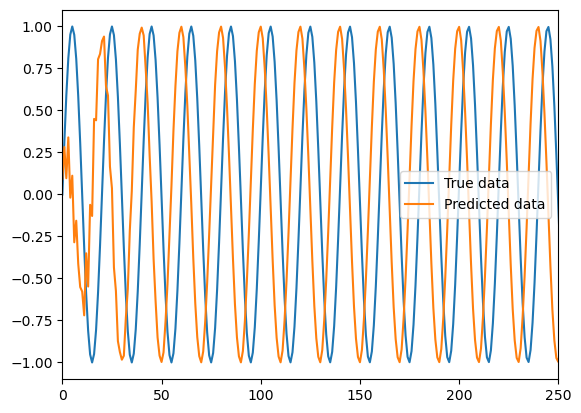

In [22]:
# On récupère les poids du RNN 
# (avec la méthode get_weights de layer)
w = {}
for layer in RNN_model.layers:
    w[layer.name] = layer.get_weights()

# On définit une fonction qui réalise explicitement une passe de RNN pour une valeur donnée en entrée
def RNN_predict(w,x,h=0):
    '''
    Entrées:
    w : poids du RNN 
    x : valeur d'entrée au temps t
    h : valeur de l'état caché au temps t [def:0]
    Sorties:
    y : valeur de sortie au temps t
    '''
    
    # calcul de h à l'instant t à partir de xt, h_{t-1}, et des poids (Wh, Uh, bh)
    Wx    = np.transpose(w["RNN"][0])
    Wh    = np.transpose(w["RNN"][1])
    bh    = np.transpose(np.reshape(w["RNN"][2], (1,hid_dim)))
    
    h     = np.tanh(np.dot(Wx, x) + np.dot(Wh, h) + bh)
      
    # calcul de y à partir de h_t et des poids (Wy, by)
    Wy    = np.transpose(w["dense"][0])
    by    = w["dense"][1]
    
    y     = np.dot(Wy,h) + by
       
    return(y,h)

# A partir de nos fonctions définies, nous pouvons calculer les sorties pour l'ensemble des batches donnés
# en entrée

# 1) Dans le premier exemple, on prédit les données indépendemment
# - On réinitialise h pour chaque batch
# [- L'entrée pour le calcul à l'instant t est la séquence du batch de l'instant t 
# (ne dépend pas de la sortie du batch précédent)]
xt = []
yt, ht = [], []
ht.append(np.zeros((hid_dim,1))) # (mode : stateful=False)

# On initialise la première entrée
xt.append(x[0,1,0])
for i in range(x.shape[1]):
    
    y, h = RNN_predict(w,xt[-1],ht[-1])
    
    # On conserve la sortie et l'état de la mémoire
    # On recopie la sortie prédite dans l'entrée suivante
    xt.append(y)
    yt.append(y)
    ht.append(h)

yt=np.reshape(np.array(yt), (len(yt),1))

# On trace les x et les y prédits
plt.plot(x.flatten(), label='True data')
plt.plot(yt, label='Predicted data')
plt.legend()
plt.xlim(0,250)
plt.show()
